In [11]:
import numpy as np
import matplotlib.pyplot as plt
import time

from BZI.pseudopots import free_PP
from BZI.plots import plot_mesh, plot_band_structure
from BZI.symmetry import make_ptvecs, make_rptvecs
from BZI.sampling import make_grid
from BZI.integration import rectangular_fermi_level, rectangular_method
from BZI.improved_tetrahedron_method import (grid_and_tetrahedra, calc_fermi_level, calc_total_energy,
                                             get_corrected_total_energy)

<IPython.core.display.Javascript object>


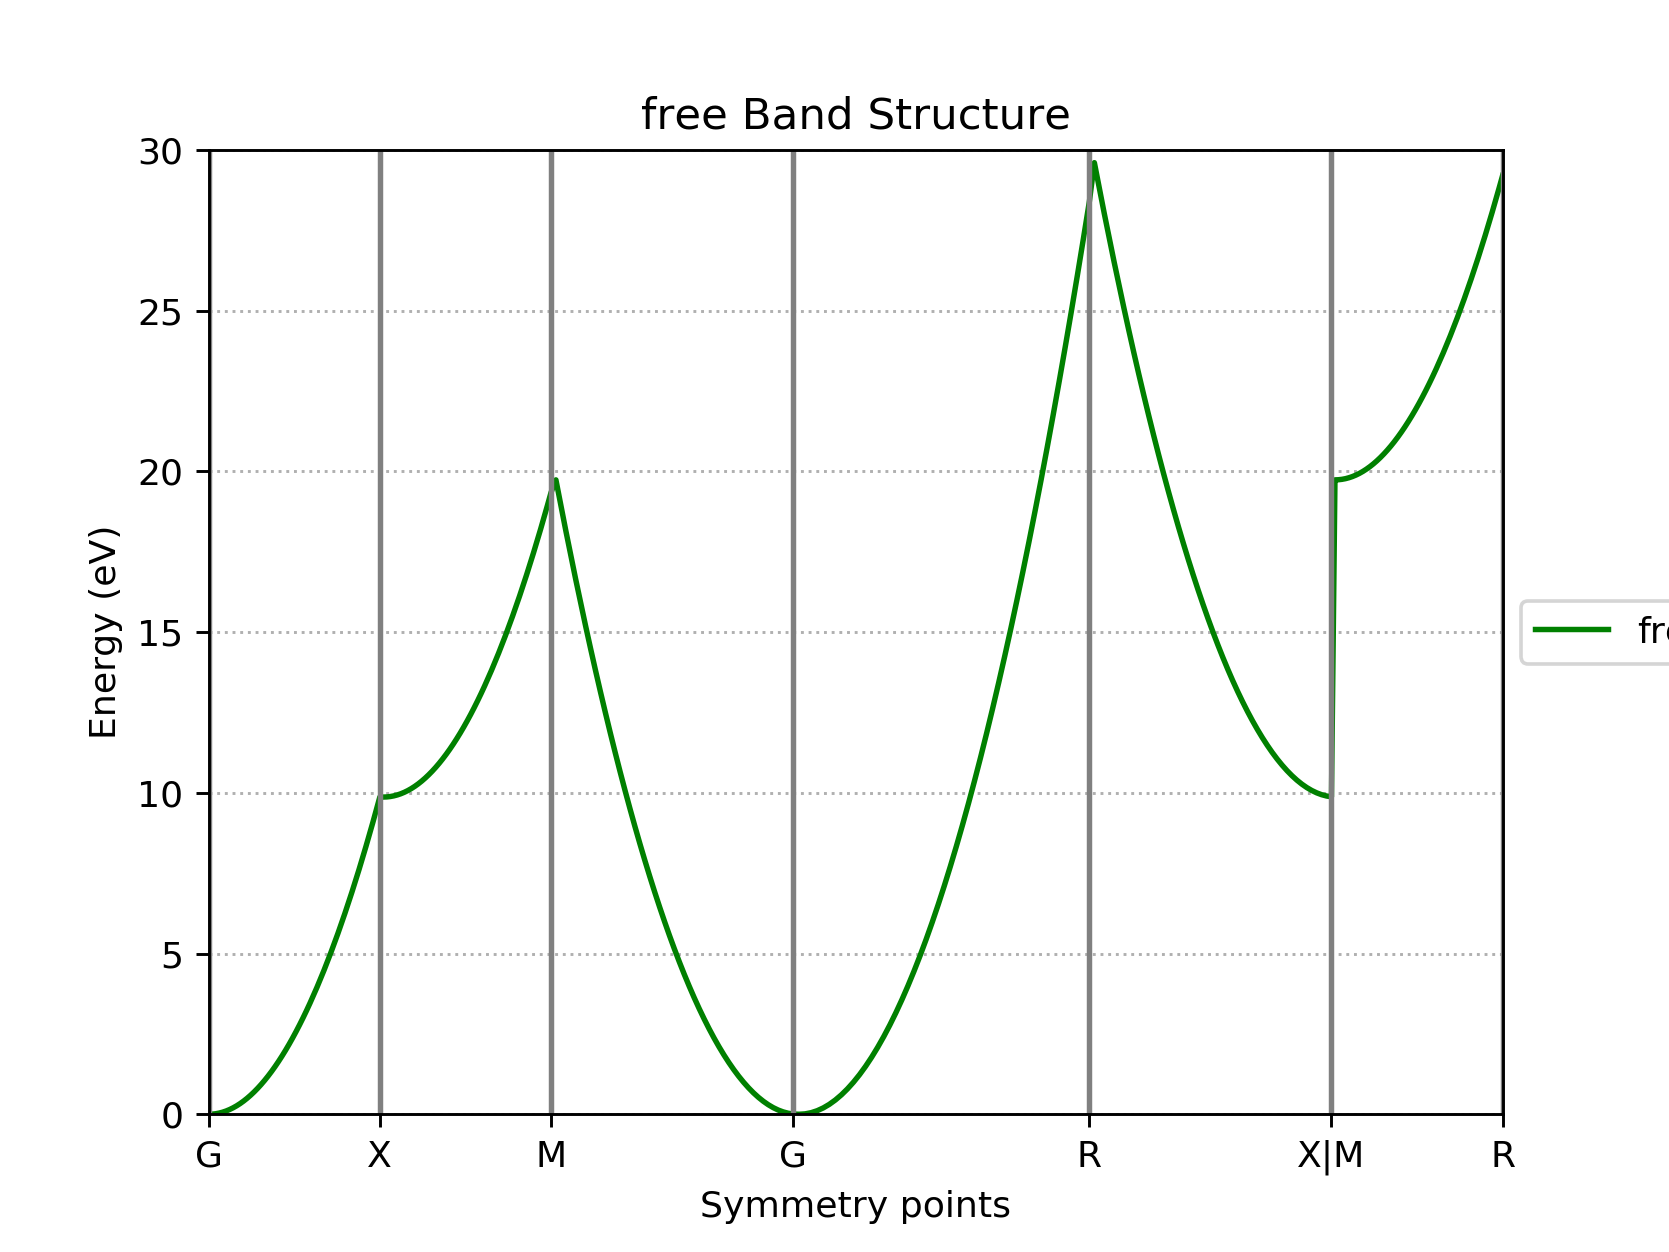

In [4]:
free_energy_shift = free_PP.eval([0.]*3,1)[0]
free_args = {"materials_list": ["free"],
           "PPlist": [free_PP],
           "PPargs_list": [{"neigvals": 1}],
           "lattice": free_PP.lattice,
           "npts": 50,
           "neigvals": 1,
           "energy_shift": free_energy_shift,
           "energy_limits": [0,30],
           "show": True}

plot_band_structure(**free_args)

In [5]:
# Calculate answer for the Fermi level and total energy.
degree = 2
# sphere_volume = 4./3*np.pi*free_PP.fermi_level**(3./degree)
occupied_volume = free_PP.lattice.reciprocal_volume*free_PP.nvalence_electrons/2
fl_answer = (3*occupied_volume/(4*np.pi))**(degree/3.)
rf = fl_answer**(1./degree)
te_answer = 4*np.pi/(3. + degree)*rf**(3. + degree)

<IPython.core.display.Javascript object>


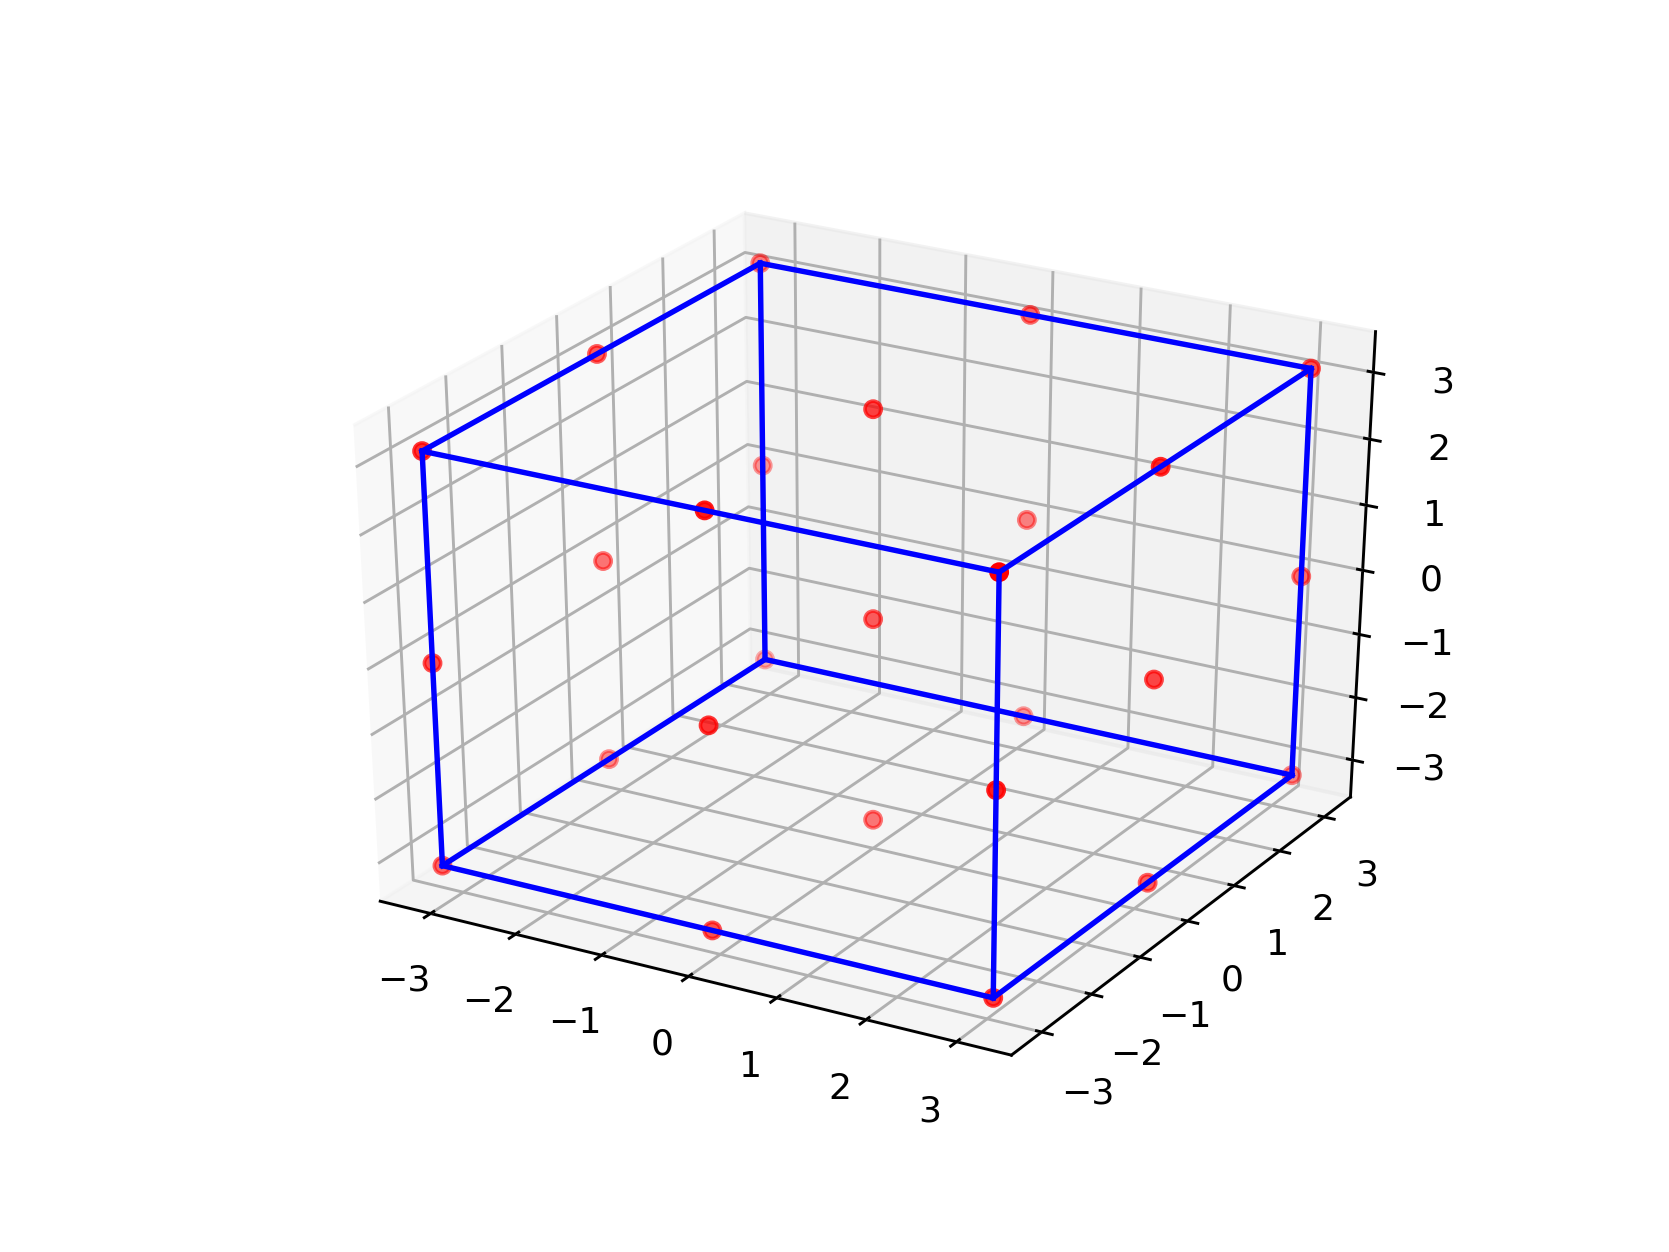

In [6]:
lat_shift = [-1./2]*3
grid_shift = [0,0,0]
grid, tetrahedra = grid_and_tetrahedra(free_PP, 2, lat_shift=lat_shift, grid_shift=grid_shift)

plot_offset = np.dot(free_PP.lattice.reciprocal_vectors, lat_shift)
plot_mesh(grid, free_PP.lattice.reciprocal_vectors, plot_offset)

In [7]:
weights = np.ones(len(tetrahedra))

free_PP.fermi_level = calc_fermi_level(free_PP, tetrahedra, weights, grid, tol=1e-3)
free_PP.total_energy = calc_total_energy(free_PP, tetrahedra, weights, grid)

print(free_PP.fermi_level)
print(free_PP.total_energy)

14.78125
1018.3574980711738


In [54]:
# Lists for storing errors
rec_flerr = []
rec_teerr = []
tet_flerr = []
tet_teerr = []
ctet_flerr = []
ctet_teerr = []

# Offsets for the tetrahedron method.
lat_shift = [-1./2]*3
grid_shift = [0,0,0]

ndivisions = list(range(2,11))
for ndivs in ndivisions:
    t0 = time.time()
    # Create the grid for rectangles
    grid_consts = [ndivs]*3
    grid_angles = [np.pi/2]*3
    grid_centering = "prim"
    grid_vecs = make_ptvecs(grid_centering, grid_consts, grid_angles)
    rgrid_vecs = make_rptvecs(grid_vecs)
    offset = -np.dot(np.linalg.inv(rgrid_vecs), np.dot(free_PP.lattice.reciprocal_vectors, [0.5]*3))
    grid = make_grid(free_PP.lattice.reciprocal_vectors, rgrid_vecs, offset)
    print("Divisions ", ndivs)
    
    # Calculate the Fermi level and total energy for rectangles.    
    free_PP.fermi_level = rectangular_fermi_level(free_PP, grid)
    free_PP.total_energy = rectangular_method(free_PP, grid)

    # Calculate the error for rectangles.
    rec_flerr.append( abs(free_PP.fermi_level - fl_answer))
    rec_teerr.append( abs(free_PP.total_energy - te_answer))
    
    # Calculate grid, tetrahedra, and weights for tetrahedra.
    grid, tetrahedra = grid_and_tetrahedra(free_PP, ndivs, lat_shift, grid_shift)
    weights = np.ones(len(tetrahedra))
    
    free_PP.fermi_level = calc_fermi_level(free_PP, tetrahedra, weights, grid, tol=1e-8)
    free_PP.total_energy = calc_total_energy(free_PP, tetrahedra, weights, grid)
    
    # Calculate the error for the tetrahedron method.
    tet_flerr.append( abs(free_PP.fermi_level - fl_answer))
    tet_teerr.append( abs(free_PP.total_energy - te_answer))
    
    # Calculate the error for the corrected tetrahedron method.
    free_PP.total_energy = get_corrected_total_energy(free_PP, tetrahedra, grid)
    ctet_teerr.append( abs(free_PP.total_energy - te_answer))

Divisions  2
number of eigenvalues  1
Divisions  3
number of eigenvalues  1
Divisions  4
number of eigenvalues  1
Divisions  5
number of eigenvalues  1
Divisions  6
number of eigenvalues  1
Divisions  7
number of eigenvalues  1
Divisions  8
number of eigenvalues  1
Divisions  9
number of eigenvalues  1
Divisions  10
number of eigenvalues  1


<IPython.core.display.Javascript object>


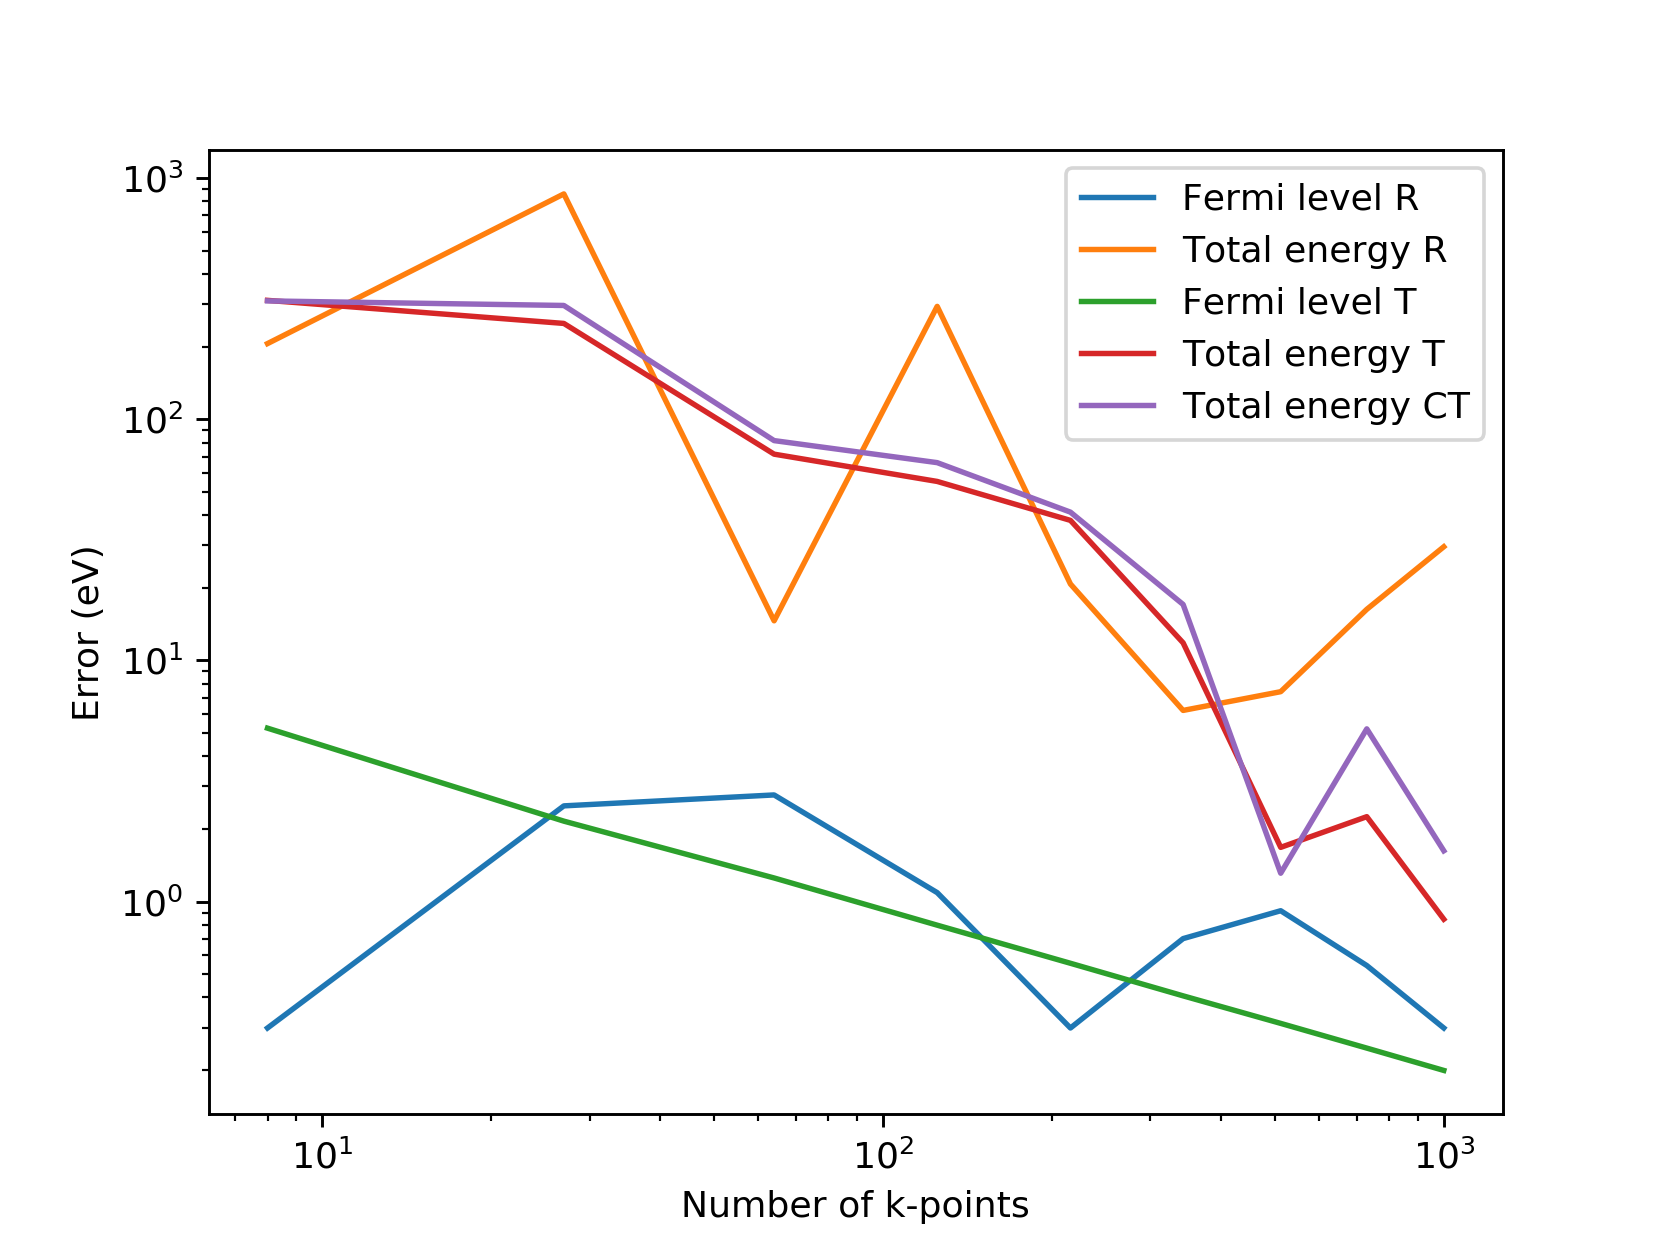

In [55]:
plt.loglog(np.array(ndivisions)**3, rec_flerr,label="Fermi level R")
plt.loglog(np.array(ndivisions)**3, rec_teerr, label="Total energy R")
plt.loglog(np.array(ndivisions)**3, tet_flerr,label="Fermi level T")
plt.loglog(np.array(ndivisions)**3, tet_teerr, label="Total energy T")
plt.loglog(np.array(ndivisions)**3, ctet_teerr, label="Total energy CT")
plt.xlabel("Number of k-points")
plt.ylabel("Error (eV)")
plt.legend()
plt.show()